In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,AveragePooling2D,MaxPool2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
from keras.utils import plot_model
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

Using TensorFlow backend.


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

<h2>Preparing the training and testing data</h2>

In [5]:
train = get_training_data('C:\Users\M ROHIT SAI\OneDrive\Desktop\MAJORCODE\chest_xray\train')
test = get_training_data('C:\Users\M ROHIT SAI\OneDrive\Desktop\MAJORCODE\chest_xray\test')
val = get_training_data('C:\Users\M ROHIT SAI\OneDrive\Desktop\MAJORCODE\chest_xray\val')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [6]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
#print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341


<h2>Visualize training images</h2>

PNEUMONIA


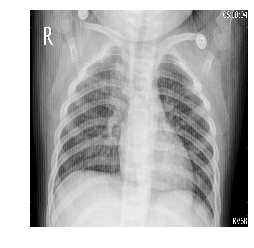

In [7]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

<h2 >We are incoprating the validation data into the training data because it does not contain enough examples. </h2>

In [8]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

In [9]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

**Data augmentation**

In [ ]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

# **CNN**

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
history_cnn = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
print("Values stored in history are ... \n", history_cnn.history)
plt.plot(history_cnn.history['acc'], label='train accuracy')
plt.plot(history_cnn.history['val_acc'], label='test accuracy')
plt.legend()
plt.show()

# **VGG16**

In [11]:
input_shape = (224, 224, 1) 

model1 = Sequential(name='vgg16-sequential')

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='block1_conv1'))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model1.add(MaxPool2D((2, 2), strides=(2, 2), name='block1_pool'))

model1.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2'))
model1.add(MaxPool2D((2, 2), strides=(2, 2), name='block2_pool'))

model1.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3'))
model1.add(MaxPool2D((2, 2), strides=(2, 2), name='block3_pool'))

model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'))
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2'))
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3'))
model1.add(MaxPool2D((2, 2), strides=(2, 2), name='block4_pool'))

model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'))
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2'))
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv3'))
model1.add(MaxPool2D((2, 2), strides=(2, 2), name='block5_pool'))

model1.add(Flatten(name='flatten'))
model1.add(Dense(4096, activation='relu', name='fc1'))
model1.add(Dense(512, activation='relu', name='fc2'))
model1.add(Dense(1, activation='sigmoid', name='predictions'))


In [12]:
model1.summary()

Model: "vgg16-sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)  

In [13]:
model1.compile(
  optimizer="adam",
  loss = "binary_crossentropy",
  metrics=['accuracy'])

In [14]:
history_vgg = model1.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=5)

Train for 118 steps, validate on 937 samples
Epoch 1/5
118/118 [==============================] - 35s 300ms/step - loss: 0.6541 - accuracy: 0.7227 - val_loss: 0.5855 - val_accuracy: 0.7407
Epoch 2/5
118/118 [==============================] - 29s 247ms/step - loss: 0.5850 - accuracy: 0.7302 - val_loss: 0.5768 - val_accuracy: 0.7407
Epoch 3/5
118/118 [==============================] - 29s 246ms/step - loss: 0.5830 - accuracy: 0.7302 - val_loss: 0.5775 - val_accuracy: 0.7407
Epoch 4/5
118/118 [==============================] - 29s 247ms/step - loss: 0.5860 - accuracy: 0.7302 - val_loss: 0.5762 - val_accuracy: 0.7407
Epoch 5/5
118/118 [==============================] - 29s 247ms/step - loss: 0.5833 - accuracy: 0.7302 - val_loss: 0.5724 - val_accuracy: 0.7407


In [15]:
model1.evaluate(X_test, y_test)

1172/1172 [==============================] - 3s 3ms/sample - loss: 0.5945 - accuracy: 0.7193


[0.5945020971037829, 0.7192833]

Values stored in history are ... 
 {'loss': [0.6562908036504582, 0.5873885806684721, 0.584832273540988, 0.587760332960875, 0.5850372355414417], 'accuracy': [0.7227115, 0.73018414, 0.73018414, 0.73018414, 0.73018414], 'val_loss': [0.58548698029625, 0.5767965706715334, 0.5775122965667139, 0.5761562992312738, 0.5723849388044189], 'val_accuracy': [0.7406617, 0.7406617, 0.7406617, 0.7406617, 0.7406617]}


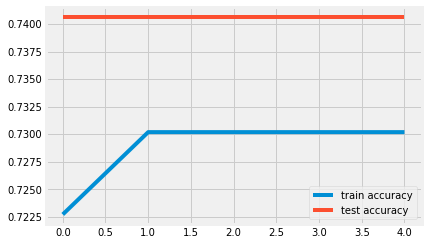

In [16]:
print("Values stored in history are ... \n", history_vgg.history)
plt.plot(history_vgg.history['accuracy'], label='train accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [17]:
pred = model1.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

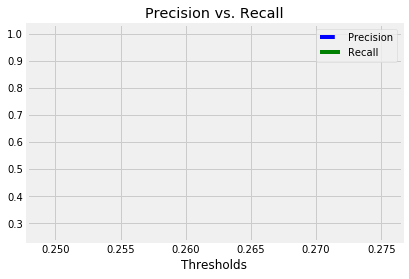

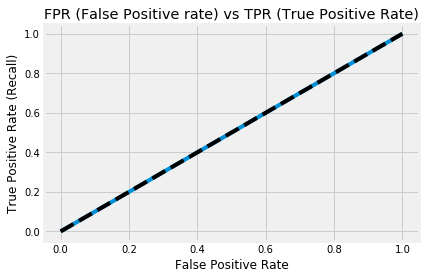

In [22]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [23]:
predictions = model1.predict(X_test)

In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
#View some results from a sample of 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

# **CUSTOMIZED CNN**

In [9]:
model2 = Sequential()
model2.add(Conv2D(64,(4,4),input_shape=(224,224,1),activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(64,(4,4),activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128,(4,4),activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(256,(4,4),activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.35))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model2.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])




In [10]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

In [11]:
history_Cus_cnn = model2.fit(datagen.flow(X_train, y_train, batch_size=32), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=25)

Train for 118 steps, validate on 937 samples
Epoch 1/25
118/118 [==============================] - 18s 156ms/step - loss: 0.5420 - acc: 0.7425 - val_loss: 0.3552 - val_acc: 0.8538
Epoch 2/25
118/118 [==============================] - 14s 117ms/step - loss: 0.3616 - acc: 0.8284 - val_loss: 0.3239 - val_acc: 0.8591
Epoch 3/25
118/118 [==============================] - 14s 123ms/step - loss: 0.3198 - acc: 0.8564 - val_loss: 0.3111 - val_acc: 0.8591
Epoch 4/25
118/118 [==============================] - 14s 117ms/step - loss: 0.2984 - acc: 0.8738 - val_loss: 0.2794 - val_acc: 0.8879
Epoch 5/25
118/118 [==============================] - 14s 121ms/step - loss: 0.2872 - acc: 0.8836 - val_loss: 0.2513 - val_acc: 0.9039
Epoch 6/25
118/118 [==============================] - 14s 117ms/step - loss: 0.2743 - acc: 0.8831 - val_loss: 0.3040 - val_acc: 0.8709
Epoch 7/25
118/118 [==============================] - 14s 120ms/step - loss: 0.2577 - acc: 0.8919 - val_loss: 0.3256 - val_acc: 0.8613
Epoch 8/25

In [12]:
model2.evaluate(X_test, y_test)

1172/1172 [==============================] - 1s 720us/sample - loss: 0.1798 - acc: 0.9334


[0.17979487064755412, 0.9334471]

Values stored in history are ... 
 {'loss': [0.5414773940181045, 0.3630530741458452, 0.32044777558474724, 0.30024090693224137, 0.28835187000944545, 0.2744645362683605, 0.25926810300187936, 0.26692979078524137, 0.2543423931408412, 0.2621708005499706, 0.24878775085463486, 0.23037445150546418, 0.23502142757598896, 0.2297190514077242, 0.2291119018749043, 0.2232420756112489, 0.2224360467368463], 'acc': [0.7424606, 0.828396, 0.8564185, 0.8737657, 0.8836402, 0.88310647, 0.89191353, 0.8855084, 0.8988524, 0.88764346, 0.8980518, 0.9095276, 0.9079263, 0.91006136, 0.91273016, 0.9186016, 0.9159328], 'val_loss': [0.35517858371154476, 0.32391221406238435, 0.3110715084676427, 0.2794425332622569, 0.2512554741338325, 0.30400371694641154, 0.32557933931035193, 0.21516380684098413, 0.23011217908009393, 0.24093180147408166, 0.21408887091415796, 0.21656382799530233, 0.2135041515753389, 0.19333819178277933, 0.2069661569251831, 0.2276364818708365, 0.2008439182853495], 'val_acc': [0.8537887, 0.85912484, 0.85912

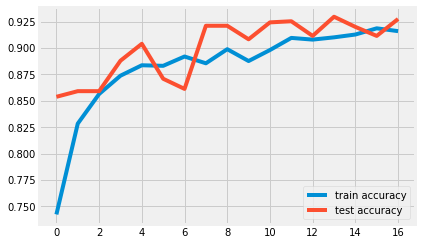

In [13]:
print("Values stored in history are ... \n", history_Cus_cnn.history)
plt.plot(history_Cus_cnn.history['acc'], label='train accuracy')
plt.plot(history_Cus_cnn.history['val_acc'], label='test accuracy')
plt.legend()
plt.show()

**Prepare data for precision vs. recall and ROC**

In [14]:
pred = model2.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

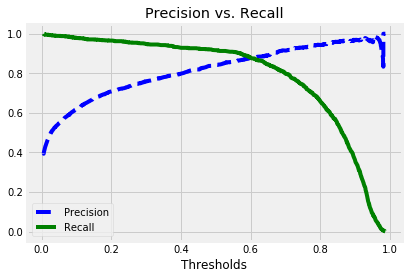

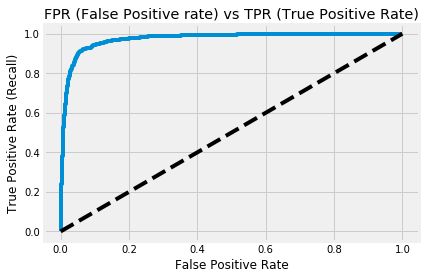

In [15]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [16]:
predictions = model2.predict(X_test)

In [17]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [18]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9308873720136519
Precision on testing set: 0.939209726443769
Recall on testing set: 0.8351351351351352


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

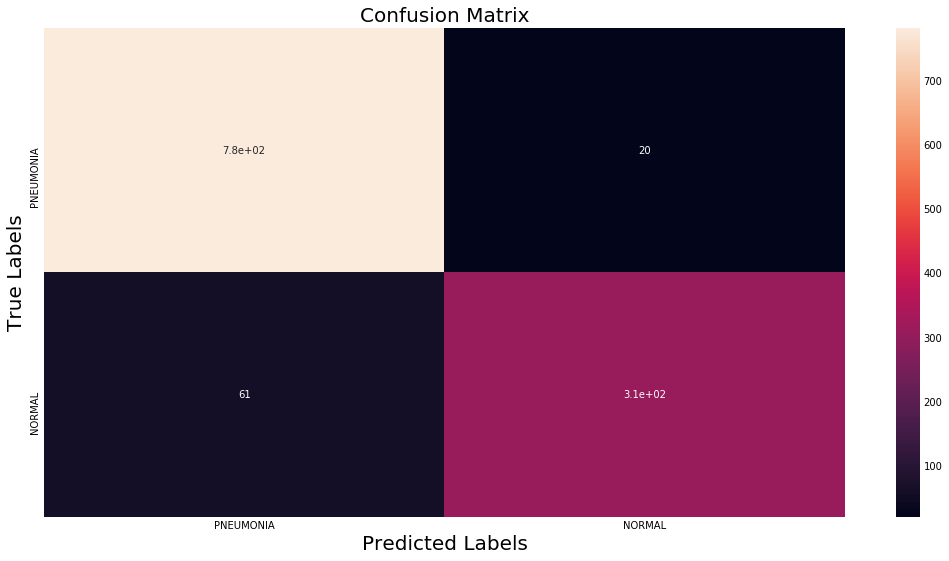

In [19]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

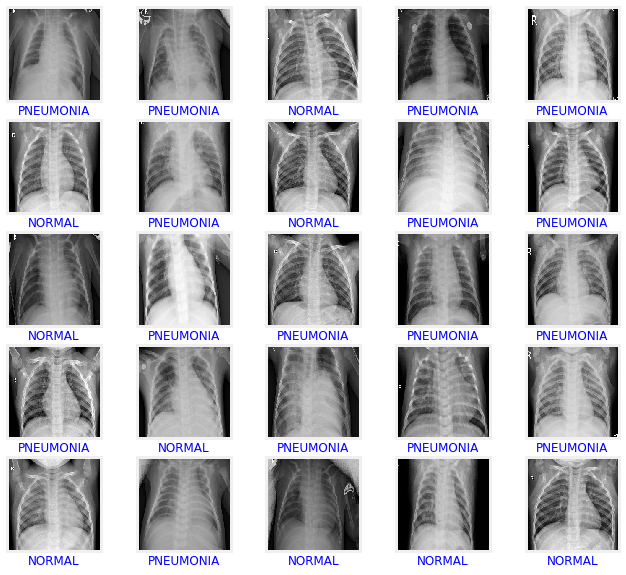

In [20]:
#View some results from a sample of 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

# **LeNet5**

In [21]:
model3 = Sequential()
model3.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 1)))
model3.add(AveragePooling2D())
model3.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model3.add(AveragePooling2D())
model3.add(Flatten())
model3.add(Dense(120, activation='relu'))
model3.add(Dense(84, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
model3.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 106, 106, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               5393400   
_________________________________________________________________
dense_3 (Dense)              (None, 84)               

In [23]:
history_LeNet5 = model3.fit(datagen.flow(X_train, y_train, batch_size=32),callbacks=[early_stop], validation_data=(X_val, y_val), epochs=25)

Train for 118 steps, validate on 937 samples
Epoch 1/25
118/118 [==============================] - 12s 101ms/step - loss: 0.5756 - accuracy: 0.7283 - val_loss: 0.5287 - val_accuracy: 0.7407
Epoch 2/25
118/118 [==============================] - 11s 96ms/step - loss: 0.5482 - accuracy: 0.7302 - val_loss: 0.5431 - val_accuracy: 0.8250
Epoch 3/25
118/118 [==============================] - 12s 104ms/step - loss: 0.4970 - accuracy: 0.7721 - val_loss: 0.4072 - val_accuracy: 0.7930
Epoch 4/25
118/118 [==============================] - 11s 96ms/step - loss: 0.4412 - accuracy: 0.8038 - val_loss: 0.3726 - val_accuracy: 0.8495
Epoch 5/25
118/118 [==============================] - 11s 95ms/step - loss: 0.4122 - accuracy: 0.8164 - val_loss: 0.3456 - val_accuracy: 0.8485
Epoch 6/25
118/118 [==============================] - 12s 99ms/step - loss: 0.4088 - accuracy: 0.8159 - val_loss: 0.3565 - val_accuracy: 0.8549
Epoch 7/25
118/118 [==============================] - 11s 96ms/step - loss: 0.4152 - accu

In [24]:
model3.evaluate(X_test, y_test)

1172/1172 [==============================] - 0s 293us/sample - loss: 0.2602 - accuracy: 0.8857


[0.26018186569620727, 0.88566554]

Values stored in history are ... 
 {'loss': [0.5748647981909137, 0.5474154534803125, 0.4940809319265563, 0.4369480242276147, 0.4107610597621927, 0.40511250998581255, 0.4071799174352808, 0.39260939758619945, 0.3767132048594783, 0.37345826990101094, 0.3697998618201507, 0.36862256161397317, 0.3555676917378222, 0.35537978350591237, 0.3391697184861995, 0.3406911691507086, 0.3442205713531447, 0.32913339723419566, 0.33697726820703183, 0.3180448318883073, 0.31492343501214953, 0.32104803316746516, 0.3060957537290412, 0.30637276917099476], 'accuracy': [0.728316, 0.73018414, 0.77208436, 0.8038431, 0.81638646, 0.8158527, 0.8131839, 0.81772083, 0.8321324, 0.830798, 0.8364025, 0.8358687, 0.8476114, 0.8476114, 0.85321593, 0.85801977, 0.84974647, 0.85935414, 0.85161465, 0.8670937, 0.86202294, 0.8582866, 0.8689618, 0.8652255], 'val_loss': [0.5287345514226239, 0.5431286230158526, 0.4071969544493147, 0.3725553732544279, 0.3455820952561011, 0.35648624683266134, 0.38271592253681946, 0.34009011896086605, 0.

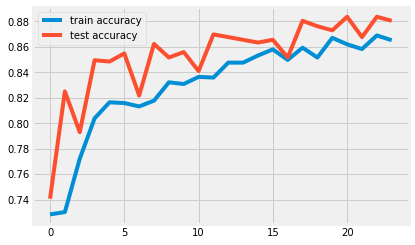

In [25]:
print("Values stored in history are ... \n", history_LeNet5.history)
plt.plot(history_LeNet5.history['accuracy'], label='train accuracy')
plt.plot(history_LeNet5.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [36]:
pred = model3.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

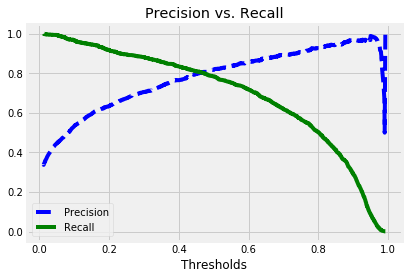

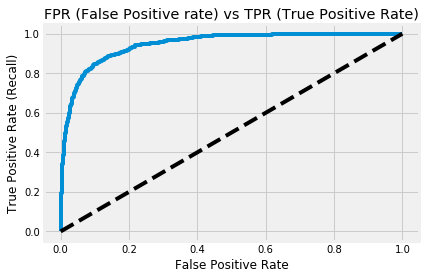

In [37]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [39]:
predictions = model3.predict(X_test)

**Set thresholds for our model, we want the results to be precise while not sacraficing too much recall**

In [40]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [41]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.878839590443686
Precision on testing set: 0.7963525835866262
Recall on testing set: 0.7774480712166172


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

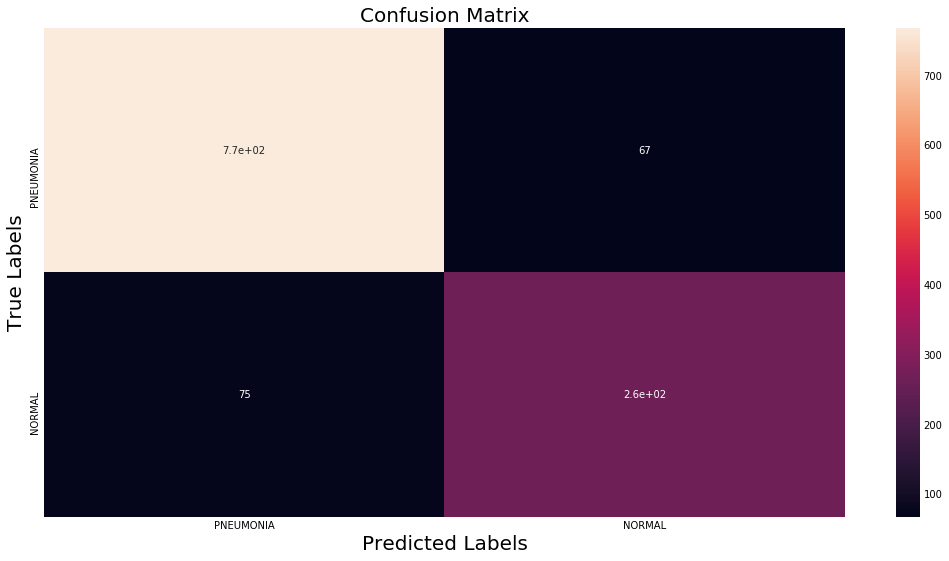

In [42]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

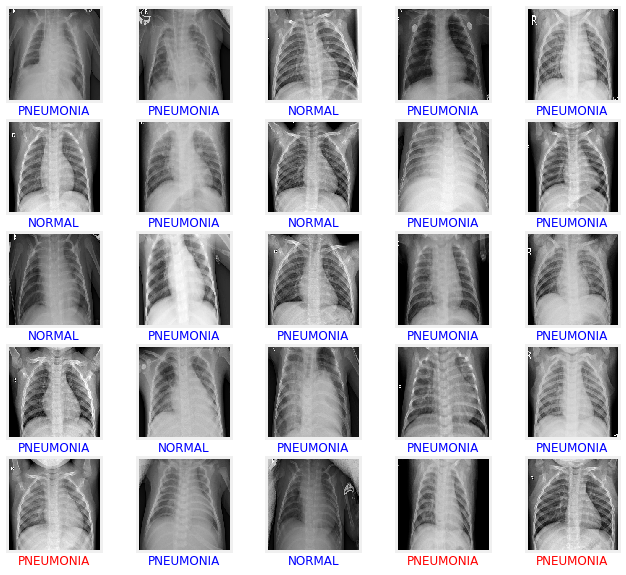

In [44]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

# **AlexNet**

In [42]:
model4 = Sequential()
model4.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,1)))
model4.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model4.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))
model4.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model4.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model4.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model4.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model4.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model4.add(Flatten())
model4.add(Dense(units=4096, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(units=256, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(units=1, activation='sigmoid'))
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [43]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 54, 54, 96)        11712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 256)      

In [45]:
history_AlexNet = model4.fit(datagen.flow(X_train, y_train, batch_size=32),callbacks=[early_stop], validation_data=(X_val, y_val), epochs=30)

Train for 118 steps, validate on 937 samples
Epoch 1/30
118/118 [==============================] - 13s 111ms/step - loss: 0.5722 - accuracy: 0.7283 - val_loss: 0.5707 - val_accuracy: 0.7449
Epoch 2/30
118/118 [==============================] - 12s 101ms/step - loss: 0.4546 - accuracy: 0.7806 - val_loss: 0.3415 - val_accuracy: 0.8420
Epoch 3/30
118/118 [==============================] - 12s 101ms/step - loss: 0.4157 - accuracy: 0.8062 - val_loss: 0.3468 - val_accuracy: 0.8346
Epoch 4/30
118/118 [==============================] - 12s 105ms/step - loss: 0.3684 - accuracy: 0.8353 - val_loss: 0.3016 - val_accuracy: 0.8677
Epoch 5/30
118/118 [==============================] - 12s 99ms/step - loss: 0.3905 - accuracy: 0.8121 - val_loss: 0.4668 - val_accuracy: 0.8164
Epoch 6/30
118/118 [==============================] - 12s 99ms/step - loss: 0.4924 - accuracy: 0.7513 - val_loss: 0.5747 - val_accuracy: 0.7407
Epoch 7/30
118/118 [==============================] - 12s 106ms/step - loss: 0.4731 - a

In [46]:
model4.evaluate(X_test, y_test)

1172/1172 [==============================] - 1s 442us/sample - loss: 0.3100 - accuracy: 0.8549


[0.30998284712993246, 0.8549488]

Values stored in history are ... 
 {'loss': [0.5721861065340768, 0.45656376404223964, 0.4169223465965944, 0.3702636027685286, 0.392256008582908, 0.4955206504576296, 0.4738550943026455], 'accuracy': [0.728316, 0.7806245, 0.80624497, 0.83533496, 0.8121164, 0.7512677, 0.77208436], 'val_loss': [0.5706688553063057, 0.3415328761047844, 0.34677646085699443, 0.30159656889537867, 0.4667815631583508, 0.5747075084688315, 0.5417136686079784], 'val_accuracy': [0.7449306, 0.8420491, 0.83457845, 0.8676627, 0.81643546, 0.7406617, 0.6926361]}


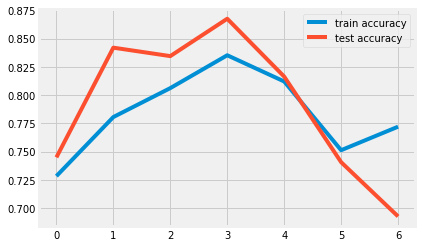

In [47]:
print("Values stored in history are ... \n", history_AlexNet.history)
plt.plot(history_AlexNet.history['accuracy'], label='train accuracy')
plt.plot(history_AlexNet.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [48]:
pred = model4.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

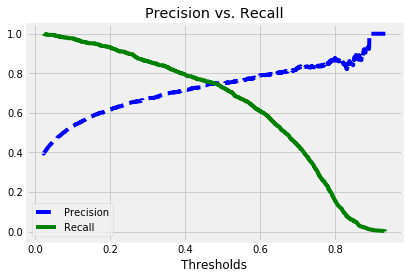

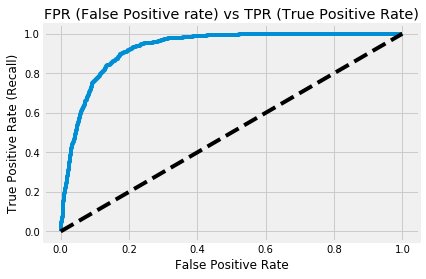

In [49]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [50]:
predictions = model4.predict(X_test)

In [51]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [52]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8353242320819113
Precision on testing set: 0.5562310030395137
Recall on testing set: 0.7956521739130434


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

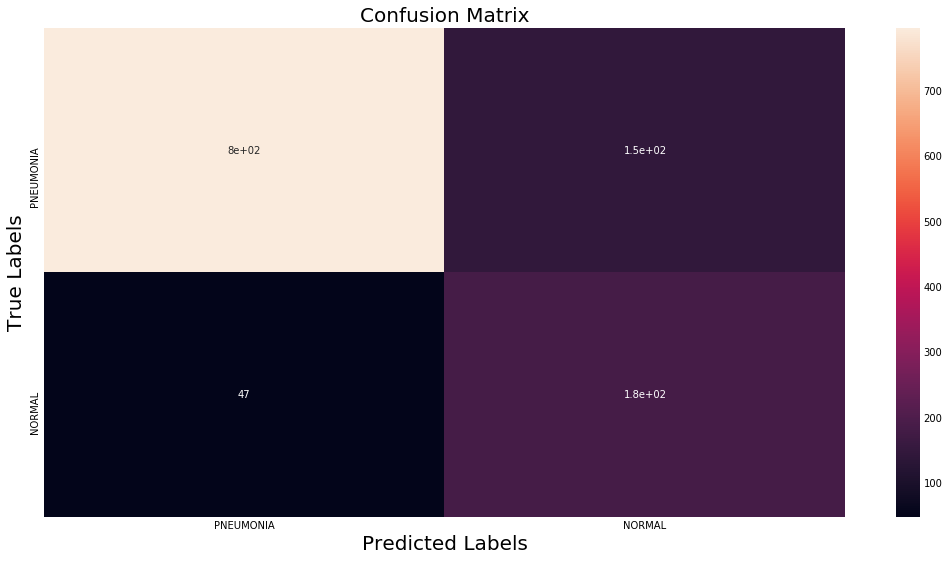

In [53]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# **COVID_NET**

In [50]:
model5 = keras.Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [51]:
# Compile the model
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 512)      

In [53]:
history_Covid_Net = model5.fit(datagen.flow(X_train, y_train, batch_size=32),callbacks=[early_stop], validation_data=(X_val, y_val), epochs=20)

Train for 118 steps, validate on 937 samples
Epoch 1/20
118/118 [==============================] - 15s 128ms/step - loss: 0.6098 - accuracy: 0.7230 - val_loss: 0.5904 - val_accuracy: 0.7407
Epoch 2/20
118/118 [==============================] - 14s 117ms/step - loss: 0.5377 - accuracy: 0.7288 - val_loss: 0.5106 - val_accuracy: 0.7268
Epoch 3/20
118/118 [==============================] - 15s 123ms/step - loss: 0.5145 - accuracy: 0.7345 - val_loss: 0.5124 - val_accuracy: 0.7353
Epoch 4/20
118/118 [==============================] - 14s 117ms/step - loss: 0.4773 - accuracy: 0.7425 - val_loss: 0.4677 - val_accuracy: 0.8036
Epoch 5/20
118/118 [==============================] - 14s 121ms/step - loss: 0.4775 - accuracy: 0.7518 - val_loss: 0.4985 - val_accuracy: 0.7748
Epoch 6/20
118/118 [==============================] - 14s 119ms/step - loss: 0.4648 - accuracy: 0.7587 - val_loss: 0.4796 - val_accuracy: 0.7449
Epoch 7/20
118/118 [==============================] - 14s 121ms/step - loss: 0.4744 -

In [54]:
model5.evaluate(X_test, y_test)

1172/1172 [==============================] - 1s 882us/sample - loss: 0.2418 - accuracy: 0.9130


[0.24183061932540997, 0.9129693]

Values stored in history are ... 
 {'loss': [0.6117085878025668, 0.540507017468528, 0.5158037160169547, 0.47891281778601796, 0.4802356582420299, 0.465071853293016, 0.47632673954228766, 0.4280148191645459, 0.4213814041894183, 0.3692483069667951, 0.33402302869962697, 0.3280296093576235, 0.3077018832345947, 0.29445118206737836, 0.29311734441322806, 0.2780394644213257, 0.2638668728918275, 0.2593695360054676], 'accuracy': [0.72297835, 0.72884977, 0.7344542, 0.7424606, 0.75180143, 0.7587403, 0.75820655, 0.78916466, 0.81265014, 0.83506805, 0.8585535, 0.8609554, 0.86736053, 0.8801708, 0.8828396, 0.88470775, 0.89751804, 0.8991193], 'val_loss': [0.59037858794822, 0.5106216260056103, 0.5123759359916475, 0.4677470084061109, 0.498539139392409, 0.47962060465756706, 0.4520018068296296, 0.3868172045960116, 0.36807371483541224, 0.35924131727778413, 0.4363412429581584, 0.2845305759089988, 0.3179578118288657, 0.2941056418380717, 0.2437120580622328, 0.24851936865260024, 0.29050055664656893, 0.400381498428

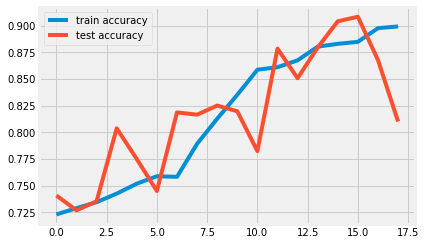

In [55]:
print("Values stored in history are ... \n", history_Covid_Net.history)
plt.plot(history_Covid_Net.history['accuracy'], label='train accuracy')
plt.plot(history_Covid_Net.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [56]:
pred = model5.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

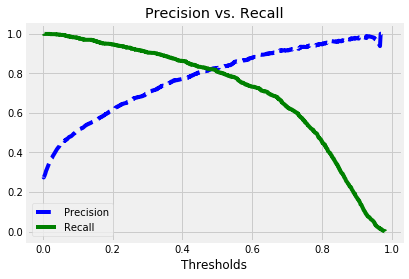

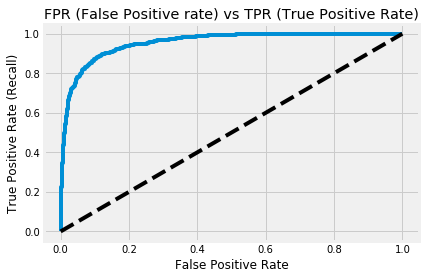

In [57]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [58]:
predictions = model5.predict(X_test)

In [59]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [60]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9069965870307167
Precision on testing set: 0.8601823708206687
Recall on testing set: 0.8179190751445087


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

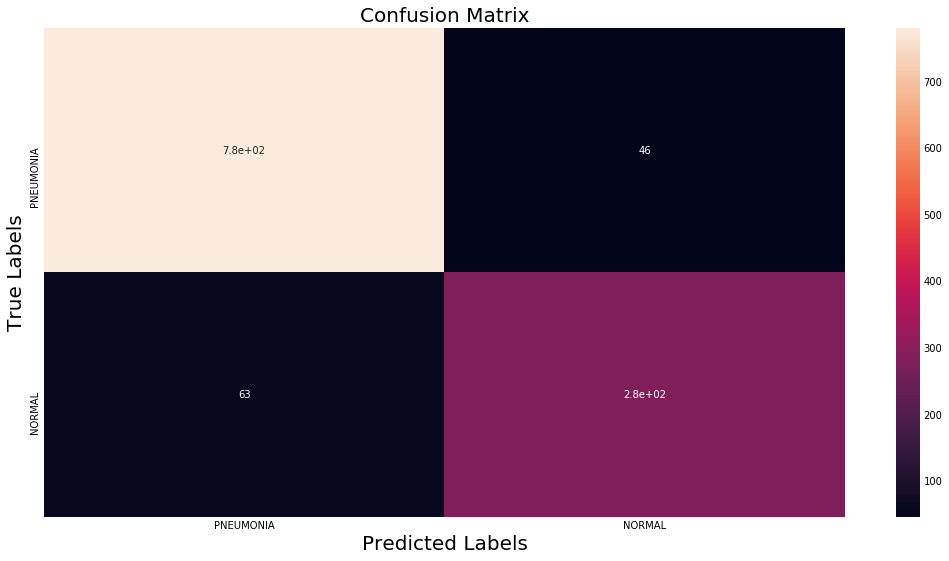

In [61]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

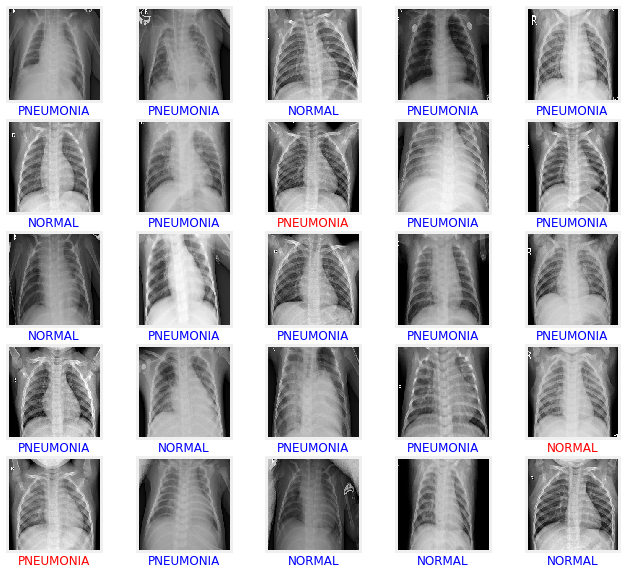

In [62]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

# **ANN**

In [17]:
model6 = Sequential([
    keras.layers.Flatten(input_shape=(224, 224, 1)),
  #  keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [18]:
# Compile the model
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3211328   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,213,441
Trainable params: 3,213,441
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_ANN = model6.fit(datagen.flow(X_train, y_train, batch_size=32),callbacks=[early_stop], validation_data=(X_val, y_val), epochs=10)

Train for 118 steps, validate on 937 samples
Epoch 1/10
118/118 [==============================] - 11s 97ms/step - loss: 0.8985 - accuracy: 0.6968 - val_loss: 0.4458 - val_accuracy: 0.7631
Epoch 2/10
118/118 [==============================] - 12s 99ms/step - loss: 0.6149 - accuracy: 0.7321 - val_loss: 0.4777 - val_accuracy: 0.7748
Epoch 3/10
118/118 [==============================] - 11s 92ms/step - loss: 0.5962 - accuracy: 0.7427 - val_loss: 0.7328 - val_accuracy: 0.6019
Epoch 4/10
118/118 [==============================] - 11s 94ms/step - loss: 0.5301 - accuracy: 0.7609 - val_loss: 0.4115 - val_accuracy: 0.8410
Epoch 5/10
118/118 [==============================] - 12s 100ms/step - loss: 0.5152 - accuracy: 0.7651 - val_loss: 0.5318 - val_accuracy: 0.7364
Epoch 6/10
118/118 [==============================] - 11s 93ms/step - loss: 0.4978 - accuracy: 0.7753 - val_loss: 0.4007 - val_accuracy: 0.8410
Epoch 7/10
118/118 [==============================] - 11s 93ms/step - loss: 0.4988 - accur

In [30]:
model6.evaluate(X_test, y_test)

1172/1172 [==============================] - 0s 249us/sample - loss: 0.3288 - accuracy: 0.8729


[0.3287659806196193, 0.87286687]

Values stored in history are ... 
 {'loss': [0.9047959354167497, 0.5497557114832619, 0.5201834141174125, 0.48805424533655145, 0.5180793084444795, 0.4931728413876833, 0.47752293781706706, 0.4960000205746262], 'accuracy': [0.688284, 0.74512947, 0.75393647, 0.7707499, 0.7534027, 0.77635443, 0.7731519, 0.7784895], 'val_loss': [0.4720326385350467, 0.4147646084284706, 0.5345513886804896, 0.3927602243143568, 0.34820236124122156, 0.6900313444427645, 0.4318207020184528, 0.37050091412431274], 'val_accuracy': [0.7812166, 0.77481323, 0.73959446, 0.8452508, 0.83457845, 0.62966913, 0.82497334, 0.810032]}


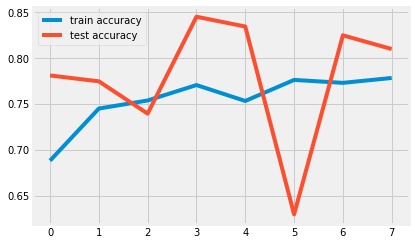

In [31]:
print("Values stored in history are ... \n", history_ANN.history)
plt.plot(history_ANN.history['accuracy'], label='train accuracy')
plt.plot(history_ANN.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

In [32]:
pred = model6.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

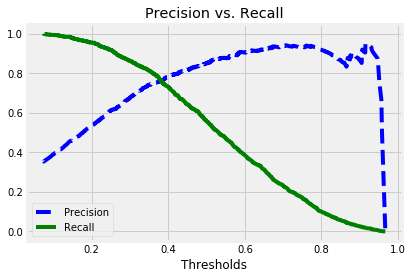

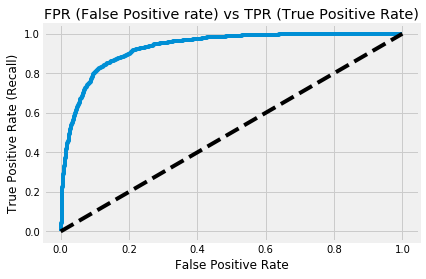

In [33]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [34]:
predictions = model6.predict(X_test)

In [35]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [36]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8822525597269625
Precision on testing set: 0.7082066869300911
Recall on testing set: 0.8472727272727273


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

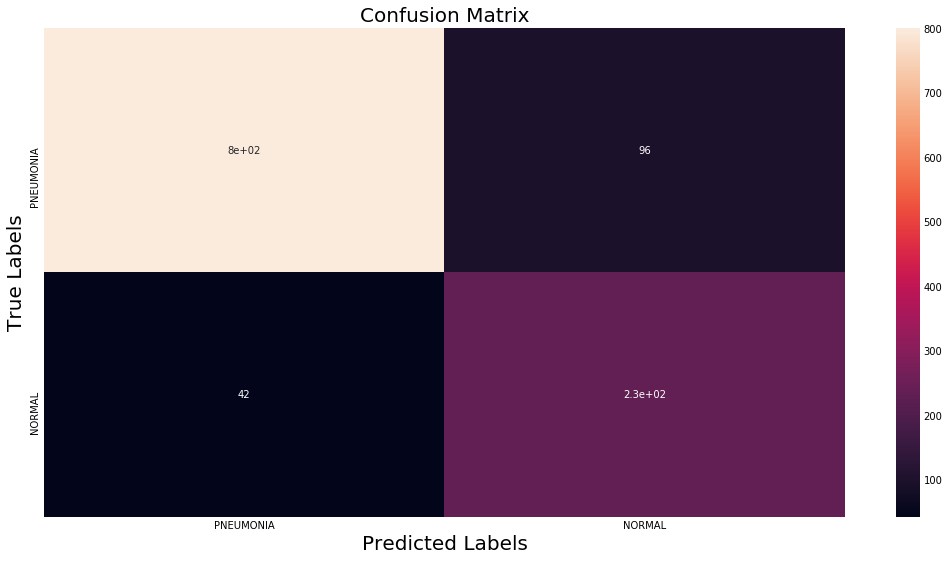

In [37]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

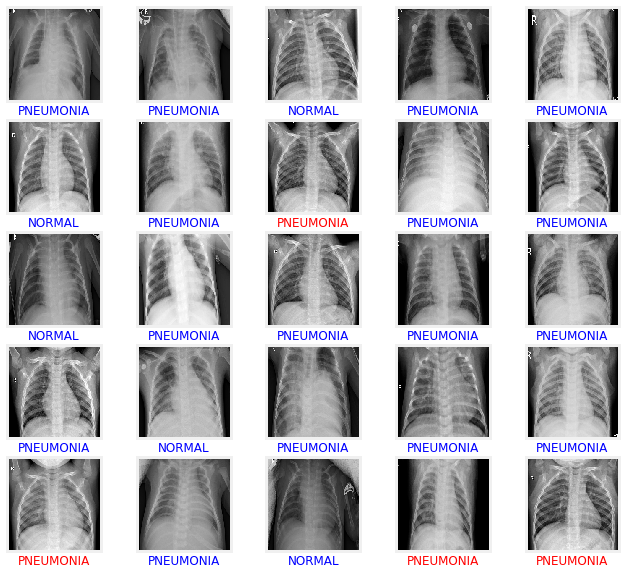

In [38]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()